# Developmental plasticity of IBAPs
Here, we will investigate whether individual brain aberration patterns (IBAPs) of prematurity are plastic to the early social environment. To this end, we will perform the following analyses:
1. Conduct a PCA to identify a main axis of variation (PC1) in IBAPs of preterm adults.
2. Investigate the impact of early social environment on adult IBAPs. Therefore, we will test the association between PC1 variables of the early social environment in preterm adults and test whether socio-economic status (SES) moderates the relationship between PC1 and gestational age.
For the moderation analysis of the effect of SES on the relationship between PC1 and gestational age, the [PROCESS toolbox](http://processmacro.org/download.html#/) is required. Please refer to the Installation requirements for further details. Adapt `process_sw_dir` to the directory where the toolbox is located on your system.


In [1]:
# manually set path to R if there are problems with the automatic detection
# import os
# os.environ['R_HOME'] = '/Library/Frameworks/R.framework/R'  # adapt to your R installation

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

In [3]:
import os
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# plot settings
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rc_file('code/matplotlibrc')

from statsmodels.formula.api import ols
from scipy.stats import spearmanr
from statsmodels.stats.multitest import fdrcorrection

# import custom functions
import sys
sys.path.append('code')
from plotting import correlation_plot, plot_pc_loadings
from utils import read_process_output
from stats import conduct_pca

# directories
centile_dir = join('outputs', 'spatial_heterogeneity')
outputs_dir_main = join('outputs', 'developmental_plasticity_IQ')
os.makedirs(outputs_dir_main, exist_ok=True)

process_sw_dir = join('code', 'processv43', 'PROCESS v4.3 for R')  # adapt to your installation

color_pt = 'darkorange'

# some settings - please adapt to your needs
dataset = 'BLS-26'  # dHCP, ABCD-10, BLS-26

outputs_dir = join(outputs_dir_main, dataset)
os.makedirs(outputs_dir, exist_ok=True)

In [4]:
# load all necessary data, i.e., deviation scores computed in script 1
try:
    ct = pd.read_csv(join(centile_dir, f'{dataset}/IBAP_CT/{dataset}_CT_centiles_per_subject.csv'), index_col=0)
    sa = pd.read_csv(join(centile_dir, f'{dataset}/IBAP_SA/{dataset}_SA_centiles_per_subject.csv'), index_col=0)
except FileNotFoundError:
    print(f'Run script 1 for all required modalities and datasets first: {dataset}')
    sys.exit()

In [5]:
# definition of variable names
dataset_vars = {
    "dHCP": {
        "extranormal_var": "supranormal",
        "cognition_var": "bsid_cog_composite",
        "cognition_label": "Bayley-III cognitive composite score",
    },
    "ABCD-10": {
        "extranormal_var": "infranormal",
        "cognition_var": "nihtbx_total",
        "cognition_label": "NIH cognition score",
        "ses_var": "SES_parent_education",
        "ses_label": "Parental education",
    },
        "BLS-26": {
        "extranormal_var": "infranormal",
        "cognition_var": "IQ",
        "cognition_label": "Full-scale IQ",
        "ses_var": "SES_at_birth",
        "ses_label": "Socioeconomic status",
    }
}

meta = dataset_vars[dataset]
extranormal_var = meta["extranormal_var"]
cognition_var = meta["cognition_var"]
cognition_label = meta["cognition_label"]
ses_var = meta.get("ses_var")
ses_label = meta.get("ses_label")

if dataset == 'ABCD-10':
    ct = ct[ct['session'] == 1]
    sa = sa[sa['session'] == 1]

# 1. PCA across regions

In [6]:
print(f'--- PCA for {dataset} ---')
pc_ct, ct_loadings = conduct_pca(ct, brain_measure='CT')
pc_sa, sa_loadings = conduct_pca(sa, brain_measure='SA')

# add PC1 of SA and CT column
ct['PC1_CT'] = pc_ct[:, 0]
sa['PC1_SA'] = pc_sa[:, 0]

# save PC loadings
ct_loadings.to_csv(join(outputs_dir, 'PCA_loadings_CT.csv'))
sa_loadings.to_csv(join(outputs_dir, 'PCA_loadings_SA.csv'))

# save PC1
covars = [cognition_var, meta.get('ses_var'), 'Age', 'age_days', 'sex', 'dx']
covars = [var for var in covars if var is not None]  # filter out variables not present in the data

ct_save = ct[['session', 'PC1_CT'] + covars]
sa_save = sa[['session', 'PC1_SA'] + covars]

ct_save.to_csv(join(outputs_dir, 'PCA_scores_CT.csv'), index=True)
sa_save.to_csv(join(outputs_dir, 'PCA_scores_SA.csv'), index=True)


--- PCA for BLS-26 ---
Conducting PCA on CT deviation scores...
Explained variance per principal component: 37.49%, 5.96% and 5.61%
Conducting PCA on SA deviation scores...
Explained variance per principal component: 40.05%, 7.40% and 4.53%


### PC1 loadings

/Users/melissa/Dokumente/PhD/01B_preterm_normative/scripts/preterm-brain-heterogeneity/code/plotting.py:340: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels, rotation=90, fontsize=10)
/Users/melissa/Dokumente/PhD/01B_preterm_normative/scripts/preterm-brain-heterogeneity/code/plotting.py:342: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


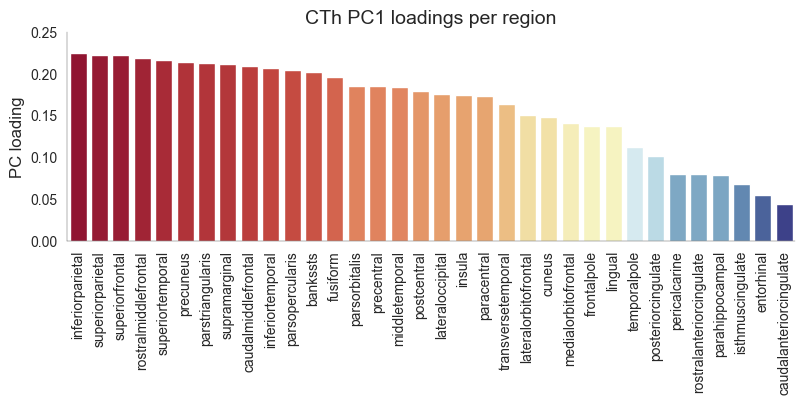

In [7]:
# CTh
loadings_ordered = pd.DataFrame(ct_loadings.sort_values(ascending=False))
loadings_ordered['order'] = np.arange(1,35,1)
loadings_ordered.index.name = 'ROI'
loadings_ordered.reset_index(inplace=True)

plot_pc_loadings(loadings_ordered, outputs_dir, brain_measure_name='CTh')

# source data
loadings_ordered.to_csv(join(outputs_dir, 'source_PCA_loadings_CT_ordered.csv'), index=False)

/Users/melissa/Dokumente/PhD/01B_preterm_normative/scripts/preterm-brain-heterogeneity/code/plotting.py:340: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels, rotation=90, fontsize=10)
/Users/melissa/Dokumente/PhD/01B_preterm_normative/scripts/preterm-brain-heterogeneity/code/plotting.py:342: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


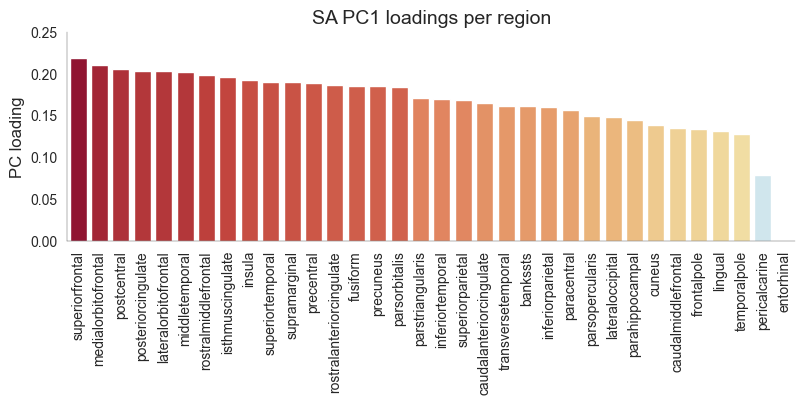

In [8]:
# SA
loadings_ordered = pd.DataFrame(sa_loadings.sort_values(ascending=False))
loadings_ordered.loc['centile_SA_entorhinal', 'PC1_loadings'] = 0  # set entorhinal to 0
loadings_ordered['order'] = np.arange(1,35,1)
loadings_ordered.index.name = 'ROI'
loadings_ordered.reset_index(inplace=True)

plot_pc_loadings(loadings_ordered, outputs_dir, brain_measure_name='SA')

# source data
loadings_ordered.to_csv(join(outputs_dir, 'source_PCA_loadings_SA_ordered.csv'), index=False)

# 2. Impact of early social environment on IBAPs
### Correlation between early social environment and IBAPs

In [9]:
out_dir = join(outputs_dir, 'social_env')
os.makedirs(out_dir, exist_ok=True)

Correlation between SES_at_birth and PC1_CT: r=-0.217 with DOF=94, p=0.033, CI=(-0.400, -0.018)


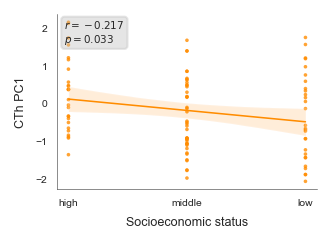

In [10]:
# socio-economic status at birth (SES)
x = ses_var
y = 'PC1_CT'
outname = join(out_dir, f'{dataset}_CT_preterm_correlation_{x}_{y}.svg')

# filter for preterms
ct_pt = ct[ct['dx'] == 'preterm']

if ses_var is not None:
    correlation_plot(x, y, data=ct_pt, color=color_pt, 
                    xlabel=ses_label, ylabel='CTh PC1', outname=outname)
    
    # source data
    ct_pt_ses_source = ct_pt[['PC1_CT', ses_var]].sort_values(by=ses_var)
    ct_pt_ses_source = ct_pt_ses_source.reset_index(drop=True).dropna()
    ct_pt_ses_source.to_csv(join(out_dir, 'source_ses_corr_cth.csv'), index=False)

Correlation between SES_at_birth and PC1_SA: r=-0.006 with DOF=94, p=0.952, CI=(-0.207, 0.194)


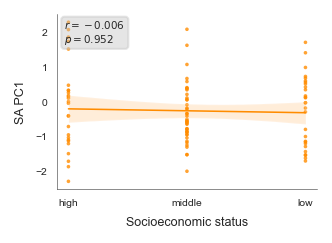

In [11]:
# socio-economic status at birth (SES)
x = ses_var
y = 'PC1_SA'
outname = join(out_dir, f'{dataset}_SA_preterm_correlation_{x}_{y}.svg')

# filter for preterms
sa_pt = sa[sa['dx'] == 'preterm']

if ses_var is not None:
    correlation_plot(x, y, data=sa_pt, color=color_pt, 
                    xlabel=ses_label, ylabel='SA PC1', outname=outname)
    
    # source data
    sa_pt_ses_source = sa_pt[['PC1_SA', ses_var]].sort_values(by=ses_var)
    sa_pt_ses_source = sa_pt_ses_source.reset_index(drop=True).dropna()
    sa_pt_ses_source.to_csv(join(out_dir, 'source_ses_corr_sa.csv'), index=False)

Correlation between PIRI and PC1_CT: r=-0.211 with DOF=89, p=0.044, CI=(-0.400, -0.006)


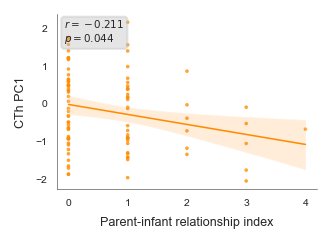

Correlation between PIRI and PC1_SA: r=-0.076 with DOF=89, p=0.474, CI=(-0.278, 0.132)


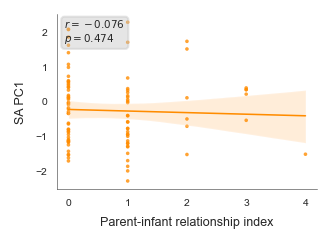

In [12]:
# parent-infant relationship index (PIRI)
if dataset == 'BLS-26':
    x = 'PIRI'
    y = 'PC1_CT'
    outname = join(out_dir, f'{dataset}_CT_preterm_correlation_{x}_{y}.svg')

    dat_piri = ct_pt[[x,y]].dropna()
    dat_piri = dat_piri[dat_piri[x] < 9] # since 9 means missing data

    correlation_plot(x, y, data=dat_piri, color=color_pt, 
                    xlabel='Parent-infant relationship index', ylabel='CTh PC1', outname=outname)

    # source data
    ct_pt_piri_source = dat_piri[['PC1_CT', 'PIRI']].sort_values(by='PIRI')
    ct_pt_piri_source = ct_pt_piri_source.reset_index(drop=True).dropna()
    ct_pt_piri_source.to_csv(join(out_dir, 'source_piri_corr_cth.csv'), index=False)

    # SA
    y = 'PC1_SA'
    outname = join(out_dir, f'{dataset}_CT_preterm_correlation_{x}_{y}.svg')

    dat_piri = sa_pt[[x,y]].dropna()
    dat_piri = dat_piri[dat_piri[x] < 9] # since 9 means missing data

    correlation_plot(x, y, data=dat_piri, color=color_pt, 
                    xlabel='Parent-infant relationship index', ylabel='SA PC1', outname=outname)

### Moderation of SES on association between GA and PC1_CT

Correlation between GA and PC1_CT: r=0.264 with DOF=94, p=0.009, CI=(0.068, 0.442)


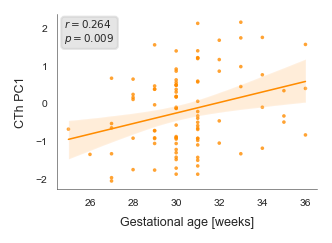

In [13]:
if dataset == 'BLS-26':
    # direct effect of GA on PC1 while controlling for interaction
    r, p = spearmanr(ct_pt['GA'], ct_pt['PC1_CT'])
    
    correlation_plot('GA', 'PC1_CT', data=ct_pt, color=color_pt, 
                    xlabel='Gestational age [weeks]', ylabel='CTh PC1', outname=join(out_dir, 'BLS-26_CT_GA_PC1.svg'))

    # print('Direct effect in moderation model:')
    # model = ols(f'GA ~ PC1_CT + (GA * {ses_var})', data=ct_pt).fit()
    # print(model.summary())


In [14]:
# save current dir for later use
cwd = os.getcwd()

In [15]:
%%R -i ct_pt -i process_sw_dir -i out_dir -i cwd -i dataset -i ses_var 


if (dataset == 'BLS-26') {
        
        setwd(process_sw_dir)
        source('process.R')
        setwd(cwd)
        
        print('Running moderation analysis...')
        # run moderation analysis: GA -> SES -> PC1
        outname = paste0(dataset, '_CT_moderation_GA_SES.txt')
        output_file <- file.path(out_dir, outname)
        sink(output_file)
        process(data = ct_pt, 
                y="PC1_CT", 
                x="GA", 
                w=ses_var,
                model=1, 
                boot = 5000,
                conf = 95,
                center = FALSE,
                plot = 1,
                save=1,
                seed=1234)

        sink()
}


********************* PROCESS for R Version 4.3.1 ********************* 
 
           Written by Andrew F. Hayes, Ph.D.  www.afhayes.com              
   Documentation available in Hayes (2022). www.guilford.com/p/hayes3   
 
*********************************************************************** 
 
PROCESS is now ready for use.
Copyright 2020-2023 by Andrew F. Hayes ALL RIGHTS RESERVED
Workshop schedule at http://haskayne.ucalgary.ca/CCRAM
 
[1] "Running moderation analysis..."


Loading moderation analysis results...


,GA,SES_at_birth,PC1_CT
0,29.00,1.0,0.0946
1,30.00,1.0,0.1335
2,32.48,1.0,0.2300
3,29.00,2.0,-0.4149
4,30.00,2.0,-0.2723
5,32.48,2.0,0.0814
6,29.00,3.0,-0.9245
7,30.00,3.0,-0.6781
8,32.48,3.0,-0.0671


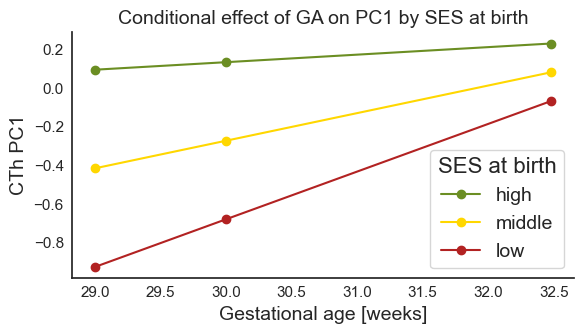

In [16]:
# restore plotting settings
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rc_file('code/matplotlibrc')

if dataset == 'BLS-26':

    ### load data from process moderation analysis in R
    print('Loading moderation analysis results...')
    mod_orig_path = os.path.join(out_dir, f'{dataset}_CT_moderation_GA_SES.txt')
    mod = read_process_output(mod_orig_path)
    display(mod)
    
    ### plot moderation results
    # label and plot settings
    ses_labels = {
        1: 'high',
        2: 'middle',
        3: 'low'
    }
    mod['SES_label'] = mod['SES_at_birth'].map(ses_labels)
    
    # source data
    mod.to_csv(join(out_dir, f'{dataset}_CT_moderation_GA_SES.csv'), index=False)
    
    sns.set(style="white")
    colors = {
        'low': 'firebrick',
        'middle': 'gold',
        'high': 'olivedrab'
    }

    ### plot interaction effect
    plt.figure(figsize=(6,3.5))

    for SES in mod['SES_label'].unique():
        subset = mod[mod['SES_label'] == SES]
        plt.plot(subset['GA'], subset['PC1_CT'], marker='o',label=f'{SES}', color=colors[SES])

    plt.xlabel('Gestational age [weeks]',  fontsize=14)
    plt.ylabel('CTh PC1', fontsize=14)
    plt.tick_params(axis='both', which='major', width=0.25, pad=0)
    plt.title('Conditional effect of GA on PC1 by SES at birth', fontsize=14)
    plt.legend(title='SES at birth', fontsize=14, title_fontsize=16)


    sns.despine()
    plt.tight_layout()
    plt.savefig(join(out_dir, f'{dataset}_CT_moderation_SES.svg'), dpi=300)

    plt.show()


### Supplementary analysis

In [17]:
# restore plotting settings
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rc_file('code/matplotlibrc')

Correlation between SES_at_birth and centile_meanCT2: r=-0.223 with DOF=94, p=0.029, CI=(-0.405, -0.023)


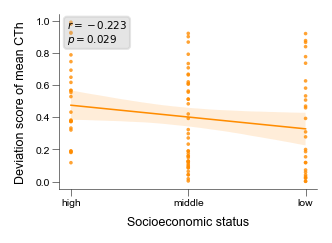

Correlation between SES_at_birth and amount_infranormal: r=0.200 with DOF=94, p=0.051, CI=(-0.000, 0.385)


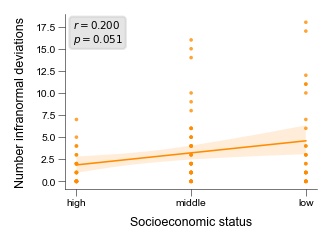

[0.051 0.051]


In [18]:
if dataset == 'BLS-26':
    
    ### deviation score of mean CTh
    x = ses_var
    y = 'centile_meanCT2'
    outname = join(out_dir, f'{dataset}_CT_preterm_correlation_{x}_{y}.svg')

    # filter for preterms
    ct_pt = ct[ct['dx'] == 'preterm']

    correlation_plot(x, y, data=ct_pt, color=color_pt, 
                    xlabel=ses_label, ylabel='Deviation score of mean CTh', outname=outname)
    
    ### Number of infranormal deviations
    x = ses_var
    y = f'amount_{extranormal_var}'
    outname = join(out_dir, f'{dataset}_CT_preterm_correlation_{x}_{y}.svg')

    correlation_plot(x, y, data=ct_pt, color=color_pt, 
                    xlabel=ses_label, ylabel=f'Number {extranormal_var} deviations', outname=outname)
    
    
    # source data
    ct_pt_ses_source = ct_pt[[ses_var, 'centile_meanCT2', y]].sort_values(by=ses_var)
    ct_pt_ses_source['SES_label'] = ct_pt_ses_source[ses_var].map(ses_labels)
    ct_pt_ses_source = ct_pt_ses_source.reset_index(drop=True).dropna()
    ct_pt_ses_source.to_csv(join(out_dir, 'source_ses_corr_cth_supp.csv'), index=False)
    
    
    print(fdrcorrection([0.029, 0.051])[1])

# 3. Impacts on cognitive outcome variability

In [19]:
out_dir = join(outputs_dir, 'cognition')
os.makedirs(out_dir, exist_ok=True)

Correlation between IQ and PC1_CT: r=0.198 with DOF=94, p=0.059, CI=(-0.003, 0.383)


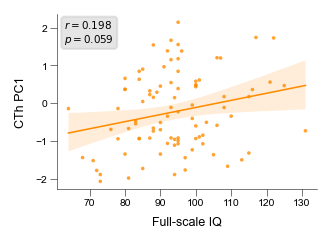

In [20]:
# PC1 of CTh
x = cognition_var
y = 'PC1_CT'
outname = join(out_dir, f'{dataset}_CT_preterm_correlation_{x}_{y}.svg')

# filter for preterms
ct_pt = ct[ct['dx'] == 'preterm']

correlation_plot(x, y, data=ct_pt, color=color_pt, 
                xlabel=cognition_label, ylabel='CTh PC1', outname=outname)


# source data
ct_pt_cog_source = ct_pt[['PC1_CT', cognition_var]].sort_values(by=cognition_var)
ct_pt_cog_source = ct_pt_cog_source.reset_index(drop=True).dropna()
ct_pt_cog_source.to_csv(join(out_dir, 'source_cogn_corr_cth.csv'), index=False)

Correlation between IQ and PC1_SA: r=0.270 with DOF=94, p=0.009, CI=(0.073, 0.446)


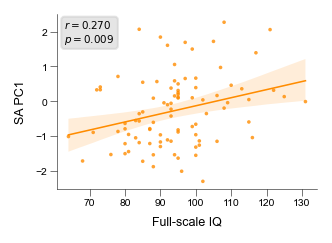

In [21]:
# PC1 of SA
x = cognition_var
y = 'PC1_SA'
outname = join(out_dir, f'{dataset}_SA_preterm_correlation_{x}_{y}.svg')

# filter for preterms
sa_pt = sa[sa['dx'] == 'preterm']

correlation_plot(x, y, data=sa_pt, color=color_pt, 
                xlabel=cognition_label, ylabel='SA PC1', outname=outname)

# source data
sa_pt_source = sa_pt[['PC1_SA', cognition_var]].sort_values(by=cognition_var)
sa_pt_source = sa_pt_source.reset_index(drop=True).dropna()
sa_pt_source.to_csv(join(out_dir, 'source_cogn_corr_sa.csv'), index=False)

## Supplementary analysis

Correlation between IQ and amount_infranormal: r=-0.214 with DOF=94, p=0.041, CI=(-0.397, -0.014)


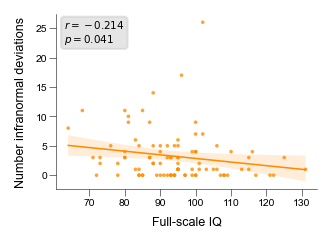

In [22]:
# number of infranormal regions SA
x = cognition_var
y = f'amount_{extranormal_var}'
outname = join(out_dir, f'{dataset}_SA_preterm_correlation_{x}_{y}.svg')

correlation_plot(x, y, data=sa_pt, color=color_pt, 
                xlabel=cognition_label, ylabel=f'Number {extranormal_var} deviations', outname=outname)

# source data
ct_pt_cognition_source = ct_pt[['PC1_CT', cognition_var]].sort_values(by=cognition_var)
ct_pt_cognition_source = ct_pt_cognition_source.reset_index(drop=True).dropna()
ct_pt_cognition_source.to_csv(join(out_dir, 'source_cogn_corr_sa_infranormal.csv'), index=False)